Loaded 8 grayscale images from dataset.


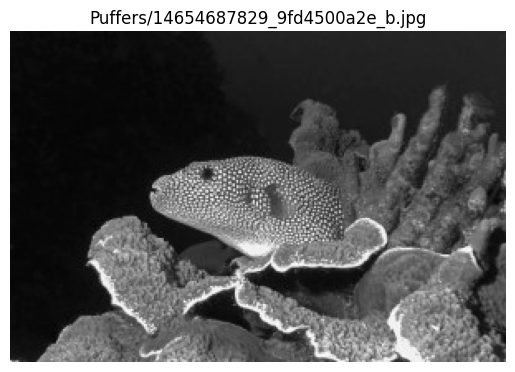

In [17]:
import cv2
import numpy as np
import math
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import glob, random
import pandas as pd

paths = glob.glob("dataset/*/*.jpg") + glob.glob("dataset/*/*.png")
sample_paths = random.sample(paths, min(8, len(paths)))

images = []
for path in sample_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        parts = path.replace("\\", "/").split("/")
        category, filename = parts[-2], parts[-1]
        images.append((f"{category}/{filename}", img))

print(f"Loaded {len(images)} grayscale images from dataset.")
plt.imshow(images[0][1], cmap='gray')
plt.title(images[0][0])
plt.axis('off')
plt.show()

In [18]:
BLOCK = 8

def dct2(block): return dct(dct(block.T, norm='ortho').T, norm='ortho')
def idct2(block): return idct(idct(block.T, norm='ortho').T, norm='ortho')

def pad_image(img, block=8):
    h, w = img.shape
    return np.pad(img, ((0, (block - h % block) % block),
                        (0, (block - w % block) % block)), mode='edge')

Q50 = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=np.float32)

def scale_quant(Q, q):
    s = 5000/q if q<50 else 200-2*q
    Qs = np.floor((Q*s+50)/100)
    Qs[Qs==0]=1
    return Qs

from collections import Counter
import heapq

def huffman_bits(symbols):
    freq = Counter(symbols)
    if len(freq) == 1: return len(symbols)
    heap = [[wt, [sym, ""]] for sym, wt in freq.items()]
    heapq.heapify(heap)
    while len(heap)>1:
        lo,hi=heapq.heappop(heap),heapq.heappop(heap)
        for p in lo[1:]: p[1]='0'+p[1]
        for p in hi[1:]: p[1]='1'+p[1]
        heapq.heappush(heap,[lo[0]+hi[0]]+lo[1:]+hi[1:])
    codes = {p[0]:p[1] for p in heapq.heappop(heap)[1:]}
    return sum(len(codes[s])*c for s,c in freq.items())

def mse(a,b): return np.mean((a.astype(float)-b.astype(float))**2)
def psnr(a,b):
    m = mse(a,b)
    return 100 if m==0 else 10*math.log10(255*255/m)

def compress(img, q=50):
    h,w = img.shape
    imgp = pad_image(img)
    Q = scale_quant(Q50, q)
    coeffs=[]
    rec = np.zeros_like(imgp,float)
    for i in range(0,imgp.shape[0],8):
        for j in range(0,imgp.shape[1],8):
            b = imgp[i:i+8,j:j+8]-128
            D = dct2(b)
            QD = np.round(D/Q)
            coeffs += QD.flatten().tolist()
            rec[i:i+8,j:j+8] = idct2(QD*Q)+128
    rec = np.clip(rec[:h,:w],0,255).astype(np.uint8)
    bits = huffman_bits(coeffs)
    return rec, bits

                                   file  quality  compression_ratio      psnr  \
0  Puffers/14654687829_9fd4500a2e_b.jpg       10           5.922855  2.594994   
1  Puffers/14654687829_9fd4500a2e_b.jpg       30           4.287552  2.625293   
2  Puffers/14654687829_9fd4500a2e_b.jpg       50           3.606013  2.635137   
3  Puffers/14654687829_9fd4500a2e_b.jpg       70           3.002402  2.638922   
4  Puffers/14654687829_9fd4500a2e_b.jpg       90           2.144600  2.641114   

            mse  
0  35775.109650  
1  35526.389333  
2  35445.957200  
3  35415.071383  
4  35397.205933  


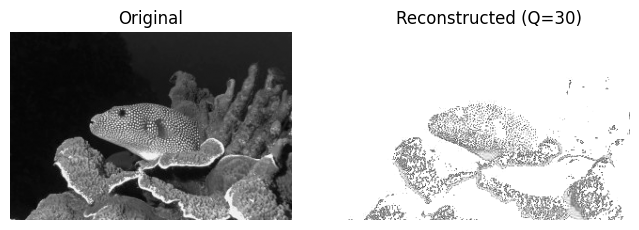

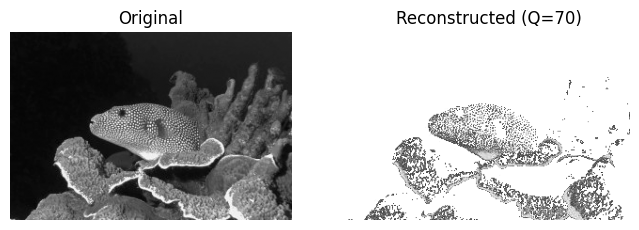

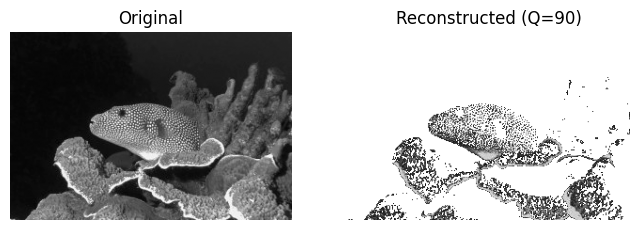

In [19]:
qualities = [10,30,50,70,90]
results = []

for name,img in images:
    for q in qualities:
        rec,bits = compress(img,q)
        orig = img.size * 8
        ratio = orig / bits
        results.append((name, q, ratio, psnr(img,rec), mse(img,rec)))

df = pd.DataFrame(results, columns=['file','quality','compression_ratio','psnr','mse'])
df.to_csv("compression_results.csv", index=False)
print(df.head())

# Visualize one example
name,img = images[0]
for q in [30,70,90]:
    rec,_ = compress(img,q)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img,cmap='gray'); plt.title('Original'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(rec,cmap='gray'); plt.title(f'Reconstructed (Q={q})'); plt.axis('off')
    plt.show()


IMAGE COMPRESSION ANALYSIS FOR: Octopus/19863130003_5e5c438d43_o.jpg
------------------------------------------------------------

## 1. Lossless Compression (Pure Huffman)
Technique: Huffman Coding on Raw Pixels
CR: 1.06:1 | BPP: 7.5325 | PSNR: Infinity

## 2. Lossy Compression (DCT Hybrid)

--- Lossy Analysis: Quality Factor = 10 ---
Technique: DCT + Quantization + Huffman
CR: 5.21:1 | BPP: 1.5351 | PSNR: 8.37 dB

--- Lossy Analysis: Quality Factor = 50 ---
Technique: DCT + Quantization + Huffman
CR: 2.76:1 | BPP: 2.8939 | PSNR: 8.61 dB

--- Lossy Analysis: Quality Factor = 90 ---
Technique: DCT + Quantization + Huffman
CR: 1.56:1 | BPP: 5.1360 | PSNR: 8.69 dB


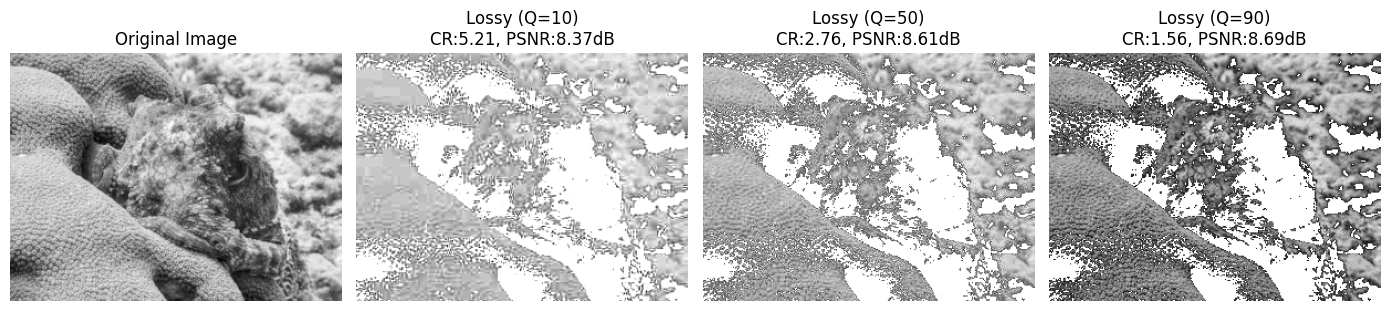


## 3. Consolidated Metrics Table for Report ---
------------------------------------------------
Type        Q Factor        CR       BPP    PSNR(dB)
------------------------------------------------
Lossless         N/A1.56    5.1360         Inf
Lossy             10      5.21    1.5351        8.37
Lossy             50      2.76    2.8939        8.61
Lossy             90      1.56    5.1360        8.69
------------------------------------------------


In [30]:
def analyze_image(name, img):
    print(f"\nIMAGE COMPRESSION ANALYSIS FOR: {name}")
    print("------------------------------------------------------------")

    print("\n## 1. Lossless Compression (Pure Huffman)")
    pixels = img.flatten().tolist()
    bits = huffman_bits(pixels)
    cr = (img.size * 8) / bits
    bpp = bits / img.size
    print("Technique: Huffman Coding on Raw Pixels")
    print(f"CR: {cr:.2f}:1 | BPP: {bpp:.4f} | PSNR: Infinity")

    print("\n## 2. Lossy Compression (DCT Hybrid)")
    qualities = [10, 50, 90]
    lossy_results = []

    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, q in enumerate(qualities, start=1):
        rec, bits = compress(img, q)
        cr = (img.size * 8) / bits
        bpp = bits / img.size
        p = psnr(img, rec)
        lossy_results.append((q, cr, bpp, p))
        print(f"\n--- Lossy Analysis: Quality Factor = {q} ---")
        print("Technique: DCT + Quantization + Huffman")
        print(f"CR: {cr:.2f}:1 | BPP: {bpp:.4f} | PSNR: {p:.2f} dB")
        axes[i].imshow(rec, cmap='gray')
        axes[i].set_title(f"Lossy (Q={q})\nCR:{cr:.2f}, PSNR:{p:.2f}dB")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n## 3. Consolidated Metrics Table for Report ---")
    print("------------------------------------------------")
    print(f"{'Type':<10}{'Q Factor':>10}{'CR':>10}{'BPP':>10}{'PSNR(dB)':>12}")
    print("------------------------------------------------")
    print(f"{'Lossless':<10}{'N/A':>10}{cr:.2f}{bpp:>10.4f}{'Inf':>12}")
    for q, cr, bpp, p in lossy_results:
        print(f"{'Lossy':<10}{q:>10}{cr:>10.2f}{bpp:>10.4f}{p:>12.2f}")
    print("------------------------------------------------")

name, img = random.choice(images)
analyze_image(name, img)

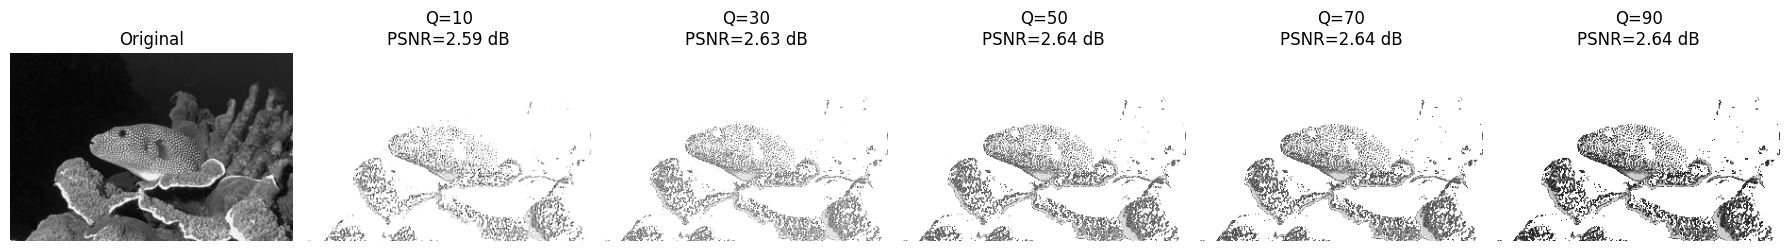

In [31]:
qualities = [10, 30, 50, 70, 90]
name, img = random.choice(images)

reconstructed = []
for q in qualities:
    rec, bits = compress(img, q)
    reconstructed.append((q, rec, psnr(img, rec)))

n = len(qualities) + 1
plt.figure(figsize=(3 * n, 4))

plt.subplot(1, n, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

for i, (q, rec, p) in enumerate(reconstructed, start=2):
    plt.subplot(1, n, i)
    plt.imshow(rec, cmap='gray')
    plt.title(f"Q={q}\nPSNR={p:.2f} dB")
    plt.axis('off')

plt.tight_layout()
plt.show()